In [1]:
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
import torch
import torchvision

In [2]:
%load_ext autoreload
%autoreload 2

from src.data import DogBreedDataset, TrainTransform
from src.data import get_test_time_transform, get_train_time_transform_simple
from src.utils import show_data_batch
from src.model import initialize_model, get_model_input_size

## data inputs

In [3]:
# set the path and directory for validation and test
val_dataset_csv = 'processed_data/train_valid_dataset.csv'
test_dataset_csv = 'processed_data/test_dataset.csv'
train_root_dir = 'data/train'
test_root_dir = 'data/test'

## training settings

In [23]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'inception_v3'
input_size = get_model_input_size(model_name)

# Number of classes in the dataset
num_classes = 120

# Batch size for testing (change depending on how much memory you have)
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

## load datasets

In [5]:
crop_size = input_size
# we use (scale_size: 256, crop_size: 224) and (scale_size: 320, crop_size: 299)
# for resize and cropping
scale_size = 320 if input_size == 299 else 256

print('input size: {} scale size: {} crop size: {}'.format(input_size, scale_size, crop_size))

input size: 299 scale size: 320 crop size: 299


In [6]:
# transforms settings
test_transform = get_test_time_transform(scale_size=crop_size, crop_size=crop_size)

In [27]:
# datasets with transforms
val_dataset = DogBreedDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=test_transform)
test_dataset = DogBreedDataset(
    csv_file=test_dataset_csv, root_dir=test_root_dir, transform=test_transform, train=False)

In [28]:
# data loaders
val_data_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_data_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# data loaders in dict
data_loaders = {
    'test': test_data_loader,
    'val': val_data_loader
}

### test your data loader before training

0 torch.Size([32, 3, 299, 299])
000621fb3cbb32d8935728e48679680e


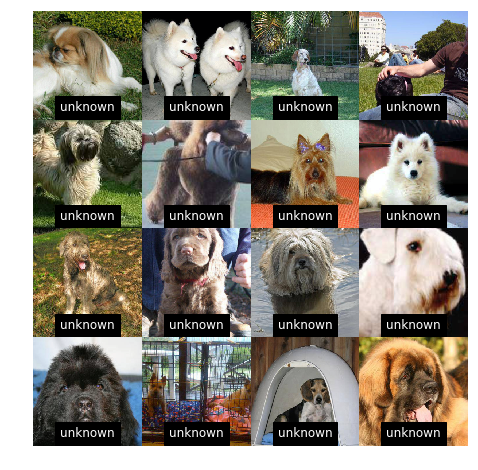

In [29]:
for batch_idx, batch_data in enumerate(test_data_loader):
    print(batch_idx, batch_data['image'].size())
    print(batch_data['id'][0])
    show_data_batch(batch_data, figsize=(8, 8), train=False)
    break

### also check your device

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('you are using device: ', device)

you are using device:  cuda:0


## initialize the model

In [32]:
# Initialize the model for this run
model_ft = initialize_model(
    model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, 
    use_pretrained=True)

# Send the model to GPU
model_ft = model_ft.to(device)

In [33]:
# Print the model we just instantiated
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## load your model weights

In [34]:
model_ft.load_state_dict(torch.load('model/dog_breed_fe_sgd_step_10epoch_simple.pt'))

## apply on validation set (for debug) and test set

In [37]:
from src.run import apply_model

In [43]:
# define your loss type
logloss_criterion = torch.nn.CrossEntropyLoss()

In [50]:
# reproduce val log loss
val_results = apply_model(
    model=model_ft, criterion=logloss_criterion, device=device, 
    data_loader=val_data_loader, in_notebook=True, val=True)


Validation Loss: 0.7406 Acc: 0.8553
Inference complete in 0m 5s


In [51]:
val_results.head()

,outputs,probs,predictions,image_ids
0,"[-0.51989007, 0.18147238, -0.39587268, 0.16766...","[0.0002525098, 0.00050918566, 0.00028585017, 0...",38,3c1be3df90b1a242325de9590db32ce2
1,"[-0.06854673, 0.5379491, -0.5291377, -0.798750...","[0.0002990202, 0.00054840115, 0.00018865499, 0...",69,74741ee49f94edb0e50edd8079a7a089
2,"[1.3514862, -0.6220412, 0.021949155, -1.280824...","[0.0015220265, 0.00021150963, 0.00040272786, 0...",45,a290e911f2c3fe117944ef7e0b42cb03
3,"[-0.6852019, -0.4400054, -0.9339374, -0.296056...","[0.00047086173, 0.00060170115, 0.00036717136, ...",16,1a98c368ffb2822653ff93475c73deb7
4,"[0.019554397, 0.9808607, -0.070513204, -0.6684...","[0.0026422741, 0.0069098365, 0.002414693, 0.00...",25,8ab20216cab9e31dc00d41cf65ac0db6


In [52]:
# apply on test set
test_results = apply_model(
    model=model_ft, criterion=logloss_criterion, device=device, 
    data_loader=test_data_loader, in_notebook=True, val=False)


Inference complete in 0m 44s


In [59]:
test_results.head()

,outputs,probs,predictions,image_ids
0,"[0.4474967, 2.1072757, -0.26321164, -0.7904812...","[0.00033391692, 0.001755785, 0.00016405211, 9....",61,000621fb3cbb32d8935728e48679680e
1,"[-0.24227236, -0.39614758, -0.23810016, -0.498...","[0.00024531712, 0.00021032972, 0.00024634282, ...",94,00102ee9d8eb90812350685311fe5890
2,"[-0.8674753, 2.471821, -0.066941954, -0.445408...","[0.00040684475, 0.011472727, 0.00090593257, 0....",40,0012a730dfa437f5f3613fb75efcd4ce
3,"[1.2044662, 0.8168019, -0.160198, -1.6677809, ...","[0.0064873328, 0.004402564, 0.0016572952, 0.00...",88,001510bc8570bbeee98c8d80c8a95ec1
4,"[3.4073703, 0.8384662, -0.54287636, -2.0691364...","[0.056362897, 0.004318495, 0.0010849832, 0.000...",100,001a5f3114548acdefa3d4da05474c2e


## get label mapping and sample submission

In [54]:
import pandas as pd

In [55]:
label_mapping = pd.read_csv('processed_data/dog_breed_train_full.csv')

In [56]:
label_mapping.head()

,id,breed,breed_label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [60]:
label_mapping = label_mapping[['breed', 'breed_label']].drop_duplicates().sort_values(
    'breed_label', ascending=True)
print(label_mapping.shape)
display(label_mapping.head())

(120, 2)


,breed,breed_label
30,affenpinscher,0
146,afghan_hound,1
15,african_hunting_dog,2
102,airedale,3
125,american_staffordshire_terrier,4


In [58]:
sample_submit = pd.read_csv('data/sample_submission.csv')
display(sample_submit.head())

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [65]:
import numpy as np

In [68]:
test_scores = np.array(test_results['probs'].values)

In [77]:
test_results.as_matrix(['probs']).reshape([-1, 120])

ValueError: cannot reshape array of size 10357 into shape (120)

In [80]:
test_scores = np.zeros((test_results.shape[0], num_classes))
print(test_scores.shape)

for i in range(test_results.shape[0]):
    test_scores[i] = test_results['probs'].values[i]

(10357, 120)


In [81]:
test_scores

array([[3.33916920e-04, 1.75578496e-03, 1.64052108e-04, ...,
        8.59963839e-05, 3.25655390e-04, 4.41354234e-04],
       [2.45317118e-04, 2.10329716e-04, 2.46342825e-04, ...,
        2.89636169e-04, 1.81474694e-04, 1.91036568e-04],
       [4.06844745e-04, 1.14727272e-02, 9.05932568e-04, ...,
        9.83827980e-04, 1.17014896e-03, 6.58086967e-04],
       ...,
       [5.32969541e-04, 1.58053543e-03, 9.30912234e-03, ...,
        1.74193922e-03, 7.47382524e-04, 5.71786833e-04],
       [7.03207625e-04, 4.63790057e-04, 9.63981656e-05, ...,
        1.94600172e-04, 3.23673914e-04, 3.86786740e-03],
       [1.89099694e-04, 1.50767667e-03, 1.48788013e-03, ...,
        2.63212412e-03, 1.06765691e-03, 2.29418700e-04]])

In [82]:
test_scores.shape

(10357, 120)

In [85]:
test_submit = test_results[['image_ids']]
test_submit.columns = ['id']
for item in label_mapping.to_dict('record'):
    test_submit[item['breed']] = test_scores[:, int(item['breed_label'])]

In [86]:
test_submit.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000334,0.001756,0.000164,0.000097,0.000115,0.000179,0.000093,0.000124,0.000227,...,0.000165,0.000184,0.000109,0.000134,0.000141,0.000148,0.000130,0.000086,0.000326,0.000441
1,00102ee9d8eb90812350685311fe5890,0.000245,0.000210,0.000246,0.000190,0.000233,0.000264,0.000119,0.000221,0.000222,...,0.000479,0.000149,0.000190,0.000234,0.000186,0.000243,0.001098,0.000290,0.000181,0.000191
2,0012a730dfa437f5f3613fb75efcd4ce,0.000407,0.011473,0.000906,0.000620,0.000470,0.000825,0.000471,0.000429,0.001002,...,0.000400,0.001104,0.000572,0.001744,0.000885,0.008212,0.000556,0.000984,0.001170,0.000658
3,001510bc8570bbeee98c8d80c8a95ec1,0.006487,0.004403,0.001657,0.000367,0.002166,0.002022,0.000653,0.002521,0.002829,...,0.004336,0.000769,0.001295,0.001469,0.001278,0.001354,0.000498,0.004221,0.000707,0.001767
4,001a5f3114548acdefa3d4da05474c2e,0.056363,0.004318,0.001085,0.000236,0.000898,0.000783,0.001936,0.000792,0.001334,...,0.002123,0.001966,0.001195,0.001017,0.000660,0.000661,0.002034,0.001329,0.002172,0.006152


In [87]:
test_submit.to_csv('processed_data/test_submit.csv', index=False)